In [18]:
# Dependencies
import pandas as pd
import pickle
import seaborn as sns
import numpy as np
from IPython.display import HTML, Image
import warnings
from nocturne.envs.base_env import BaseEnv
from pathlib import Path
from pyvirtualdisplay import Display
import torch
import imageio
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils.config import load_config_nb
from utils.sb3.reg_ppo import RegularizedPPO

sns.set('notebook', font_scale=1.1, rc={'figure.figsize': (10, 5)})
sns.set_style('ticks', rc={'figure.facecolor': 'none', 'axes.facecolor': 'none'})
%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings("ignore")
plt.set_loglevel('WARNING')

# Settings
models_config = load_config_nb('model_config')
env_config = load_config_nb('env_config')

### Helper functions

In [19]:
MAPPING = {
    np.nan: "BC",
    0.0: "PPO",
    0.005: "HR-PPO | λ = 0.005",
    0.01: "HR-PPO | λ = 0.01",
    0.025: "HR-PPO | λ = 0.025",
    0.05: "HR-PPO | λ = 0.05",
    0.5: "HR-PPO | λ = 0.5",
    0.2: "HR-PPO | λ = 0.2",
    0.1: "HR-PPO | λ = 0.1",
}

def mean_plus_min_std(ser: pd.Series, scale: float = 100) -> str:
    return f"{ser.mean() * 100:.2f} ± {(ser * 100).std():.2f}"

def mean_perc(ser: pd.Series) -> float:
    return ser.mean() * 100

### **Load results**

In [20]:
PATH_TO_DATA = '../evaluation/results/df_agg_performance_100_02_13_13_27.csv'

In [21]:
# Load data
df_all = pd.read_csv(PATH_TO_DATA)
df_all["Agent_+"] = df_all["Reg. weight"].replace(MAPPING)

In [22]:
# Sanity check: Check how many unique scene_ids we have
display(df_all.scene_id.sort_values().unique().shape)

display(df_all['Reg. weight'].unique())

(100,)

array([0.   , 0.01 , 0.05 , 0.005, 0.025,   nan])

In [23]:
df_all.head() 

,scene_id,veh_id,veh_int_paths,min_step_diff,tot_int_paths,num_total_vehs,goal_rate,off_road,veh_veh_collision,Agent,Train agent,Dataset,Eval mode,Reg. weight,Agent_+
0,tfrecord-00031-of-01000_18.json,11,0.0,NaN,0.0,2,1.0,0.0,0.0,PPO,Self-play,Train,Self-play,0.0,PPO
1,tfrecord-00031-of-01000_18.json,3,0.0,NaN,0.0,2,1.0,0.0,0.0,PPO,Self-play,Train,Self-play,0.0,PPO
2,tfrecord-00057-of-01000_356.json,16,0.0,NaN,0.0,6,1.0,0.0,0.0,PPO,Self-play,Train,Self-play,0.0,PPO
3,tfrecord-00057-of-01000_356.json,0,0.0,NaN,0.0,6,1.0,0.0,0.0,PPO,Self-play,Train,Self-play,0.0,PPO
4,tfrecord-00057-of-01000_356.json,91,0.0,NaN,0.0,6,1.0,0.0,0.0,PPO,Self-play,Train,Self-play,0.0,PPO


### 1. **Aggregate performance**


In [24]:
df_agg_perf = df_all.pivot_table(
    index=['Agent_+', 'Train agent', 'Dataset', 'Eval mode'],
    values=['goal_rate', 'veh_veh_collision', 'off_road'],
    aggfunc=mean_perc
)

heatmap_styles = {'goal_rate': sns.color_palette("Greens", as_cmap=True),
                  'off_road': sns.color_palette("Reds", as_cmap=True),
                  'veh_veh_collision': sns.color_palette("Reds", as_cmap=True)}

styled_df = df_agg_perf.style.format("{:.2f}")\
    .background_gradient(cmap=heatmap_styles['goal_rate'], subset=['goal_rate'])\
    .background_gradient(cmap=heatmap_styles['off_road'], subset=['off_road'])\
    .background_gradient(cmap=heatmap_styles['veh_veh_collision'], subset=['veh_veh_collision'])

styled_df

### 2. Compare HR-PPO to PPO performance

Eval mode                                Log-replay  Self-play
                            Reg. weight                       
mean_perc goal_rate         0.000              72.6  92.287582
                            0.005              74.4  96.732026
                            0.010              75.9  95.555556
                            0.025              79.0  93.333333
                            0.050              79.1  87.450980
          off_road          0.000               3.6   4.575163
                            0.005               1.8   2.222222
                            0.010               2.6   3.398693
                            0.025               2.6   2.745098
                            0.050               4.4   3.006536
          veh_veh_collision 0.000              25.6   3.267974
                            0.005              24.5   1.045752
                            0.010              22.8   1.699346
                            0.025              18.7   4.313725
                            0.050              10.8   5.228758

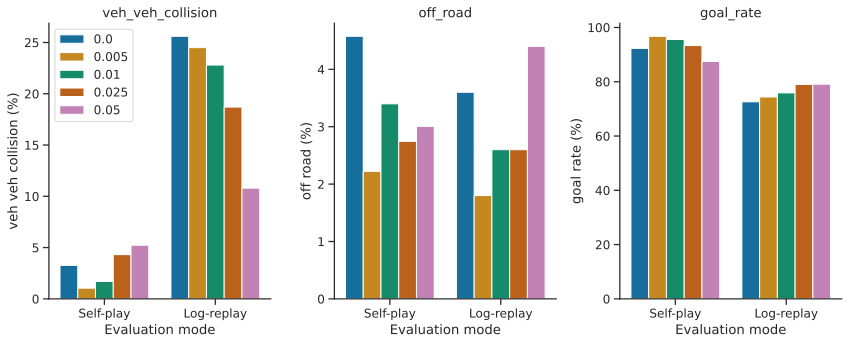

In [25]:
df_all_hr_ppo = df_all[df_all['Agent_+'] != 'BC']

df_agg_coll_ppo = df_all_hr_ppo.pivot_table(
    index=['Eval mode'],
    columns=['Reg. weight'],
    values=['goal_rate', 'veh_veh_collision', 'off_road'], # Num total vehicles doesn't make sense
    aggfunc=[mean_perc],
)
sns.set_palette('colorblind')
display(df_agg_coll_ppo.T)

# Flatten the MultiIndex columns
# Here, you only need to preserve the 'Agent_+' and the metric names ('goal_rate', etc.) in the column names
df_agg_coll_ppo.columns = [f'{metric}_{agent}' for _, metric, agent in df_agg_coll_ppo.columns]

# Reset the index to make sure everything is a column in the DataFrame
df_reset = df_agg_coll_ppo.reset_index()

# Melt the DataFrame to long format
df_melted = df_reset.melt(id_vars='Eval mode', var_name='Metric_Agent', value_name='Value')

# Separate 'Metric' and 'Agent_+' from 'Metric_Agent'
df_melted[['Metric', 'Agent']] = df_melted['Metric_Agent'].str.rsplit('_', n=1, expand=True)

# Define the order of the hue levels explicitly
hue_order = ['self-play', 'log-replay']

# Create the plots
fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharex=True)

# Extract unique metrics for plotting
metrics = ['veh_veh_collision', 'off_road', 'goal_rate']

for i, metric in enumerate(metrics):
    # Filter the data for each metric
    df_filtered = df_melted[df_melted['Metric'] == metric]
    sns.barplot(
        data=df_filtered, 
        x='Eval mode', 
        y='Value', 
        hue='Agent',
        order=['Self-play', 'Log-replay'],
        ax=axes[i]
    )
    axes[i].set_title(metric)
    axes[i].set_ylabel(f'{metric.replace("_", " ")} (%)')
    axes[i].set_xlabel('Evaluation mode')
    
    # Only add the legend to the last subplot
    if i == 0:
        axes[i].legend(loc='upper left')
    else:
        axes[i].get_legend().remove()

plt.tight_layout()
sns.despine()

### Question 2: Do PPO and HR-PPO struggle with the same scenes?

In [27]:
# fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# for idx, eval_mode in enumerate(df_agg_coll_ppo.columns.levels[0]):
#     df_select = df_agg_coll_ppo[eval_mode]
#     sns.regplot(data=df_select, x="HR-PPO | λ = 0.025", y="PPO", ax=axes[idx])
#     corr, _ = scipy.stats.pearsonr(df_select["HR-PPO | λ = 0.025"], df_select["PPO"])
#     axes[idx].set_title(f"Evaluation mode: {eval_mode} | Corr: {corr:.2f}")
#     # sns.scatterplot(data=df_agg_coll_by_scene[eval_mode], x='HR-PPO', y="PPO", ax=axes[idx])

#     axes[idx].grid(True, alpha=0.5)
#     axes[idx].set_xlim(-2, 80)
#     axes[idx].set_ylim(-2, 80)
# sns.despine()

# plt.savefig(f'../evaluation/figures/isolate_error/errors_corr_log_replay.pdf', bbox_inches="tight")

### Question 3: Are the same scenes difficult in self-play and log-replay mode?

In [28]:
# fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)

# for idx, agent in enumerate(["PPO", "HR-PPO | λ = 0.025"]):

#     df_agent_lr = df_agg_coll_by_scene['Self-play'][agent]
#     df_agent_sp = df_agg_coll_by_scene['Log-replay'][agent]
    
#     sns.regplot(x=df_agent_lr.values, y=df_agent_lr.values, ax=axes[idx])
#     corr, _ = scipy.stats.pearsonr(df_agent_lr.values, df_agent_sp.values)
#     axes[idx].set_title(f"Agent: {agent} | Corr: {corr:.2f}")
    
#     axes[idx].grid(True, alpha=0.5)
#     axes[idx].set_xlabel("Self-play")
#     axes[idx].set_ylabel("Log-replay")
#     sns.despine()

# plt.show()

### Question 4: What drives the difficulty, the scene as a whole (coordination) or individual trajectories 

In [29]:
INT_BINS = [-1, 0, 1, 2, float('inf')]
INT_LABELS = ['0', '1', '2', '3+']

STEP_BINS = [0, 10, 20, 30, 40, float('inf')]
STEP_LABELS = ['0-1 s', '1-2 s', '2-3 s', '3-4 s', '4+ s']

In [30]:
# Aggregate results in self-play evaluation mode
df_sp = df_all[df_all['Eval mode'] == 'Self-play']
df_sp['int_path_cat'] = pd.cut(df_sp['veh_int_paths'], bins=INT_BINS, labels=INT_LABELS, include_lowest=True)
df_sp['step_diff_cat'] = pd.cut(df_sp['min_step_diff'], bins=STEP_BINS, labels=STEP_LABELS, include_lowest=True)
df_sp_agg = df_sp.groupby(['Reg. weight', 'int_path_cat'])[['goal_rate', 'off_road', 'veh_veh_collision']].mean()
df_sp_agg['goal_rate'] = df_sp_agg['goal_rate'] * 100
df_sp_agg['off_road'] = df_sp_agg['off_road'] * 100
df_sp_agg['veh_veh_collision'] = df_sp_agg['veh_veh_collision'] * 100

# Aggregate results in self-play evaluation mode
df_lr = df_all[df_all['Eval mode'] == 'Log-replay']
df_lr['int_path_cat'] = pd.cut(df_lr['veh_int_paths'], bins=INT_BINS, labels=INT_LABELS, include_lowest=True)
df_lr['step_diff_cat'] = pd.cut(df_lr['min_step_diff'], bins=STEP_BINS, labels=STEP_LABELS, include_lowest=True)
df_lr_agg = df_lr.groupby(['Reg. weight', 'int_path_cat'])[['goal_rate', 'off_road', 'veh_veh_collision']].mean()
df_lr_agg['goal_rate'] = df_lr_agg['goal_rate'] * 100
df_lr_agg['off_road'] = df_lr_agg['off_road'] * 100
df_lr_agg['veh_veh_collision'] = df_lr_agg['veh_veh_collision'] * 100

In [31]:
display(df_sp_agg)

goal_rate   off_road  veh_veh_collision
Reg. weight int_path_cat                                          
0.000       0              92.949907   4.267161           3.153989
            1              94.444444   2.777778           3.472222
            2              77.777778  14.814815           5.555556
            3+             96.428571   0.000000           0.000000
0.005       0              95.732839   2.782931           1.484230
            1              98.611111   1.388889           0.000000
            2             100.000000   0.000000           0.000000
            3+            100.000000   0.000000           0.000000
0.010       0              95.361781   2.597403           2.226345
            1              94.444444   6.944444           0.694444
            2              98.148148   3.703704           0.000000
            3+            100.000000   0.000000           0.000000
0.025       0              94.619666   3.153989           2.782931
            1              86.805556   2.083333          11.111111
            2              94.444444   1.851852           3.703704
            3+            100.000000   0.000000           0.000000
0.050       0              91.280148   3.525046           2.597403
            1              75.694444   2.777778          13.888889
            2              81.481481   0.000000          11.111111
            3+             85.714286   0.000000           0.000000

In [32]:
display(df_lr_agg)

goal_rate   off_road  veh_veh_collision
Reg. weight int_path_cat                                         
0.000       0             79.741935   3.354839          18.709677
            1             57.055215   1.840491          42.331288
            2             18.181818  13.636364          70.454545
            3+            38.888889   5.555556          61.111111
0.005       0             81.290323   2.322581          17.032258
            1             58.895706   0.000000          42.331288
            2             31.818182   0.000000          68.181818
            3+            22.222222   0.000000          77.777778
0.010       0             81.677419   3.225806          16.258065
            1             60.736196   0.613497          39.877301
            2             40.909091   0.000000          63.636364
            3+            50.000000   0.000000          50.000000
0.025       0             82.580645   2.322581          15.741935
            1             69.325153   4.294479          26.380368
            2             54.545455   0.000000          40.909091
            3+            72.222222   5.555556          22.222222
0.050       0             82.064516   3.870968           8.387097
            1             69.938650   6.134969          20.858896
            2             68.181818   6.818182          13.636364
            3+            61.111111   5.555556          16.666667

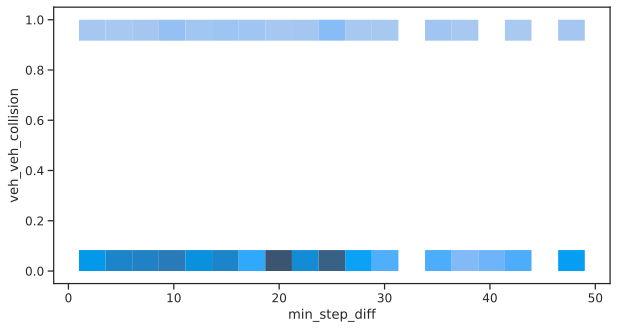

In [33]:
df_intersect_sp = df_sp[df_sp['veh_int_paths'] > 0]

sns.histplot(data=df_intersect_sp, x='min_step_diff', y='veh_veh_collision');

In [34]:
df_sp['Reg. weight'].unique()

array([0.   , 0.01 , 0.05 , 0.005, 0.025,   nan])

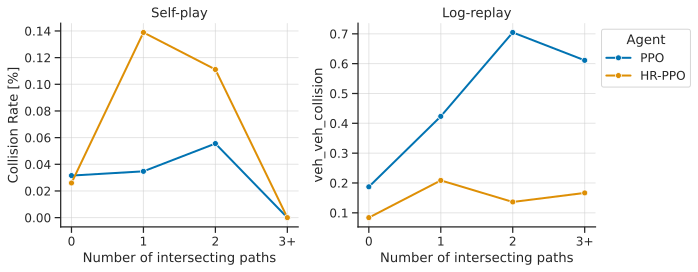

In [35]:
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2

REG_WEIGHT = 0.05
ERRORBAR = None

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Self-play
sns.lineplot(
    x='int_path_cat', 
    y='veh_veh_collision', 
    data=df_sp[df_sp['Reg. weight'] == 0.0], 
    ax=axs[0],
    errorbar=ERRORBAR,
    marker='o',
)

sns.lineplot(
    x='int_path_cat', 
    y='veh_veh_collision', 
    data=df_sp[df_sp['Reg. weight'] == REG_WEIGHT], 
    ax=axs[0],
    errorbar=ERRORBAR,
    marker='o',
)

# Log-replay
sns.lineplot(
    x='int_path_cat', 
    y='veh_veh_collision', 
    data=df_lr[df_lr['Reg. weight'] == 0.0], 
    ax=axs[1],
    marker='o',
    errorbar=ERRORBAR,
    label='PPO',
)

sns.lineplot(
    x='int_path_cat', 
    y='veh_veh_collision', 
    data=df_lr[df_lr['Reg. weight'] == REG_WEIGHT], 
    ax=axs[1],
    marker='o',
    errorbar=ERRORBAR,
    label=f'HR-PPO',
)

axs[1].legend(title='Agent', loc='upper left', bbox_to_anchor=(1, 1), facecolor='white')
axs[0].set_title(r'Self-play')
axs[1].set_title(r'Log-replay')
axs[0].set_ylabel('Collision Rate [%]')
axs[0].set_xlabel('Number of intersecting paths')
axs[1].set_xlabel('Number of intersecting paths')
fig.subplots_adjust(bottom=0.25)
axs[1].grid(True, alpha=0.5), axs[0].grid(True, alpha=0.5)

plt.tight_layout()
sns.despine()

In [36]:
df_sp[df_sp['Reg. weight'] == 0.0]['int_path_cat'].value_counts()

int_path_cat
0     539
1     144
2      54
3+     28
Name: count, dtype: int64

In [37]:
df_lr[df_lr['Reg. weight'] == 0.0]['int_path_cat'].value_counts()

int_path_cat
0     775
1     163
2      44
3+     18
Name: count, dtype: int64

### 5. Qualitative analysis

In [38]:
def create_video(image_array, filename, *, fps=4, loop=500):
    with imageio.get_writer(filename, duration=1_000 / fps, loop=loop) as writer:
        for img in image_array:
            img = np.moveaxis(img, [0, 1, 2], [2, 0, 1])
            writer.append_data(img)


def display_gif(filename, width=500, height=500):
    display(
        Image(
            data=open(filename, "rb").read(), format="gif", width=width, height=height
        )
    )

In [7]:
# Load dict with number of intersecting paths per scene
with open('../evaluation/scene_info/train_1000_01_31_15_18.pkl', 'rb') as handle:
    scene_to_paths_dict = pickle.load(handle)
    
# Create an empty dataframe
df_intersect = pd.DataFrame(columns=['traffic_scene', 'veh_id', 'intersecting_paths'])

# Populate the dataframe
for traffic_scene, data in scene_to_paths_dict.items():
    veh_ids = data['veh_id']
    intersecting_paths = data['intersecting_paths']

    # Repeat traffic_scene for each veh_id
    traffic_scene_col = [traffic_scene] * len(veh_ids)

    # Append to the dataframe
    df_intersect = pd.concat([df_intersect, pd.DataFrame(list(zip(traffic_scene_col, veh_ids, intersecting_paths)),
                                     columns=['traffic_scene', 'veh_id', 'intersecting_paths'])])

# Reset index
df_intersect.reset_index(drop=True, inplace=True)

In [38]:
NUM_INTERSECTING_PATHS = 0

VIDEO_PATH = f'../evaluation/videos/intersecting_paths_{NUM_INTERSECTING_PATHS}'

# Sample a random scene
random_scene = df_intersect[df_intersect['intersecting_paths'] == NUM_INTERSECTING_PATHS].sample(n=1) 

scene_name = str(random_scene.traffic_scene.values[0])
focus_veh_id = random_scene.veh_id.values[0]
print(random_scene)

                         traffic_scene veh_id intersecting_paths
1486  tfrecord-00237-of-01000_379.json     20                  0


In [42]:
MODEL = "HR-PPO"
VIDEO_PATH = "../evaluation/videos"

if MODEL == "PPO":
    policy = RegularizedPPO.load(
    f'../{models_config.hr_ppo_models_dir_self_play}/{models_config.best_overall_models[0].name}'
)

elif MODEL == "HR-PPO": 
    policy = RegularizedPPO.load(
        f'../{models_config.hr_ppo_models_dir_self_play}/{models_config.best_overall_models[2].name}'
    )        

env_config.max_num_vehicles = 1
env_config.data_path = '../data_full/train'
env = BaseEnv(env_config)

obs_dict = env.reset(filename=scene_name)
frames = []

for time_step in range(90):
    
    action_dict = {}
    for agent_id in obs_dict:
        # Get observation
        obs = torch.from_numpy(obs_dict[agent_id]).unsqueeze(dim=0)

        # Get action
        action, _ = policy.predict(obs, deterministic=True)
        action_dict[agent_id] = int(action)

    
    if time_step % 1 == 0:
        with Display(backend="xvfb") as disp:
            render_scene = env.scenario.getImage(
                img_width=1600,
                img_height=1600,
                draw_target_positions=True,
                padding=50.0,
                source=env.controlled_vehicles[0],
                view_width=120,
                view_height=120,
                rotate_with_source=True,
            )
            frames.append(render_scene.T)

    # Step
    obs_dict, rew_dict, done_dict, info_dict = env.step(action_dict)
    
    if done_dict['__all__']:
        print(info_dict[agent_id])
        break

INFO:root:No regularization weight specified, using default PPO.


{'goal_achieved': False, 'collided': True, 'veh_veh_collision': True, 'veh_edge_collision': False}


In [22]:
# Path(f"{VIDEO_PATH}/{scene_name}_{MODEL}").parent.mkdir(parents=True, exist_ok=True)
# create_video(frames, f"{VIDEO_PATH}/{scene_name}_{MODEL}.gif", fps=4)
# display(HTML(f"<h3>{MODEL} - {scene_name}</h3>"))
# display_gif(f"{VIDEO_PATH}/{scene_name}_{MODEL}.gif")